# Entrega: Entender los datos

*Estudiante: Wendy Galvis Larios*

Ahora que ya aprendió a usar PySpark para exploración y calidad de datos, lo invitamos a que realice el proceso de entendimiento de datos de la tabla movimientosCopia que se encuentra en la base de datos WWImportersTransactional, que registra el movimiento en inventario de un producto. La empresa no compartió información de las tablas de clientes ni de proveedores para esta actividad.

En esta actividad le recomendamos revisar el diccionario de datos suministrado y en particular la información relacionada con la tabla movimientosCopia. Si tienen alguna duda relacionada con esta tabla deben incluirla en las preguntas o aclaraciones que le entreguen al negocio. En relación a los datos Wide World Importers menciona:

* La cantidad máxima de productos movidos es 50 millones por transacción
* Existen 236.668 movimientos de producto realizados desde 2013
* Los movimientos están relacionados con 228.265 clientes
* El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
* Actualmente tenemos 13 proveedores

## Configuración e importe de paquetes

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
from pyspark.sql.functions import countDistinct 
from pyspark.sql.functions import sum, col
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [6]:
# Conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
db_user = 'Estudiante_8_202413'
db_psswd = 'aabb1122'
PATH='./'

## Perfilamiento de los datos

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
Se crea la función para conectarse a la fuente de datos y retornar un dataframe.

In [7]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Debemos colunsultar únicamente la tabla: movimientosCopia

In [10]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

### Entendimiento general de datos

In [ ]:
movimientos.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

La consulta anterior muestra la tabla de movimientos y evidencia que continene información **relacionada con el movimiento, la transacción, el producto, el cliente, el proveeder y con la órden**. La información del movimiento es su identificador <i>TransaccionProductoID</i>, la fecha en la que se realizó el movimiento <i>FechaTransaccion</i>, el identificador de la factura <i>InvoiceID</i> y la cantidad de productos que se retiraron o ingresaron al inventario <i>Cantidad</i>. La información del producto es su identificador <i>ProductoID</i>, así como la información de la transacción es su identificador <i>TipoTransaccionID</i>, la información del cliente es su identificador <i>ClienteID</i>, la información del proveedor es su identificador <i>ProveedorID</i> y la información de la orden es su identificador <i>OrdenDeCompraID</i>

In [12]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

Para entender la estructura de datos con la que estamos trabajando usamos .schema, que nos muestra el tipo de dato de cada columna. En la tabla de ordenes encontramos que hay 3 variables de tipo Integer (TransaccionProductoID, ProductoID, TipoTransaccionID), 3 variables de tipo Double (ClienteID, InvoiceID, Cantidad), y 3 variables de tipo String (ProveedorID, OrdenDeCompraID, FechaTransaccion). Una pregunta que podríamos realizar al negocio sería por qué se tienen diferentes tipos de datos para las columnas relacionadas con identificadores y si es posible ajustarlos todos a una columna tipo Integer, de tal forma que no tengamos inconvenientes a futuro por la diferencia en los tipos de datos.

Ahora revisamos cuantos datos tenemos disponibles.

In [14]:
print((movimientos.count(), len(movimientos.columns)))

(204292, 9)


**¿Cuantos datos tenemos?** En total tenemos 204.292 movimientos y 9 variables.

### Revisión de reglas de negocio 

La primera regla que asegura que la cantidad máxima de productos movidos es 50 millones por transacción. Para esto verificamos ningun registro de la columna <i>Cantidad</i> supere el valor de 50 millones

In [17]:
movimientos_cantidad = movimientos.select('TransaccionProductoID','Cantidad').where((movimientos['Cantidad'] > 50000000))
movimientos_cantidad.show()

+---------------------+--------+
|TransaccionProductoID|Cantidad|
+---------------------+--------+
+---------------------+--------+



Lo anterior muestra que no existe ninguna transacción que supere la cantidad máxima de 50.000.000. La revisión se hizo asumiendo que cada registro representa una transacción diferente ya que esta representado por la llave primaria <i>TransaccionProductoID</i>. Sin embargo, como una última verificación, comprobaremos que la columna <i>TransaccionProductoID</i> solo tiene valores únicos.

In [21]:
movimientos.select(countDistinct("TransaccionProductoID")).collect()[0][0]

173659

In [25]:
valores_repetidos = movimientos.groupBy('TransaccionProductoID').count().filter(col('count') > 1)
valores_repetidos.show(5)
valores_repetidos.count()

+---------------------+-----+
|TransaccionProductoID|count|
+---------------------+-----+
|               197953|    2|
|               101055|    2|
|               309597|    2|
|               209326|    2|
|               213516|    2|
+---------------------+-----+
only showing top 5 rows



30633

Al realizar esta verificación encontramos que <i>TransaccionProductoID</i>, que se describe como la llave primaria no tiene valores únicos. Se debe solicitar una aclaración al negocio respecto a esto, ya que la llave primaria debe ser única y no debe tener valores repetidos.
Dado esto, entonces verificaremos si no hay transacciones que superen los 50.000.000 sumando la columna <i>Cantidad</i> por cada <i>TransaccionProductoID</i> único.

In [27]:
cantidad_transaccion = movimientos.groupBy('TransaccionProductoID').agg(sum('Cantidad').alias('TotalCantidad'))
transacciones_mayores = cantidad_transaccion.filter(col('TotalCantidad') > 50000000)
transacciones_mayores.show()

+---------------------+-------------+
|TransaccionProductoID|TotalCantidad|
+---------------------+-------------+
+---------------------+-------------+



Esta comprobación muestra que la regla si se cumple, ninguna de las transacciones supera los 50 millones. La segunda regla indica que existen 236.668 movimientos de producto realizados desde 2013. Para esto, revisaremos la cantidad de registros en la base de datos y las fechas.

In [28]:
print((movimientos.count()))

204292


In [29]:
movimientos.distinct().count()

173659

In [35]:
movimientos.agg({"FechaTransaccion": "min"}).show()

+---------------------+
|min(FechaTransaccion)|
+---------------------+
| 2013-12-31 07:00:...|
+---------------------+



Sobre esta regla podemos concluir que se cumple parcialmente pues en primer lugar, la cantidad de movimientos indicados no coincide con la cantidad de registros, mientras que la regla indica que hay 236.668 movimientos, los datos tienen solamente 204.292 y además muchos de esos movimientos son registros duplicados, por lo que la diferencia es aún mayor, ya que la cantidad de movimientos reales son 173.659. Ademas de esto, aunque la fecha mínima se dio en el año 2013, todos los registros correspondientes a este año son del último día (31 diciembre), es posible que se hayan compartido los datos de forma incorrecta y se hayan omitido registros del 2013, sin embargo, se debe consultar al negocio sobre los datos faltantes.

La tercera regla indica que los movimientos están relacionados con 228.265 clientes. Con las verificaciones anteriores es posible concluir que esta regla tampoco se cumple, ya que la cantidad de clientes asociados a los movimientos no puede superar la cantidad de registros en la tabla de movimientos. Sin embargo, a continuación revisaremos la cantidad de identificadores únicos asociados a clientes para verificar la cantidad real de clientes actualmente.

In [37]:
movimientos.select("ClienteID").distinct().count()

664

Evidentemente esta regla no se cumple y la cantidad de clientes asociados a los movimientos dista mucho de lo indicado por el negocios. Debemos reportar la inconsitencia.
La cuarta regla menciona que el formato de fechas manejado es YYYY-MM-DD HH:MM:SS, en nuestro caso la única columna asociada a fecha es <i>FechaTransaccion</i>, para verificar que los datos cumplen esta regla usaremos  expresiones regulares.

In [39]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(movimientos.count())+", número de movimientos con formato correcto: "+str(cumplenFormato.count()))

Número total de movimientos: 204292, número de movimientos con formato correcto: 140038


In [42]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show(5)

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 25,2014|
|     Dec 10,2015|
|     Dec 04,2015|
|     Dec 23,2015|
|     Jul 27,2015|
+----------------+
only showing top 5 rows



(64254, None)

A partir de lo anterior, encontramos que hay 64.254 registros que no cumplen con el formato especificado. Sin embargo, parece que solo es un problema de formato ya que los registros que no cumple de cualquier forma representan una fecha, simplemente esta expresada de una forma diferente. En este caso informaremos al negocio que debemos hacer un ajuste en el formato de la fecha para que todos tengan el formato especificado y así evitar inconvenientes a futuro.

Finalmente, la última regla establece que se tienen 13 proveedores. A continuación, realizaremos la verificación.

In [43]:
movimientos.select("ProveedorID").distinct().count()

4

De forma similar a las reglas anteriores, evidenciamos que la cantidad de proveedores que aparecen en la tabla de movimientos es inferior. Esto refuerza la idea de que es posible que se haya compartido la base de datos incompleta. Además de esto, verificaremos la cantidad de registros vacíos en la columna relacionada con proveedores y clientes.

In [53]:
proveedores_vacios = movimientos.filter((col("ProveedorID").isNull()) | (col("ProveedorID") == '')).count()
clientes_vacios = movimientos.filter((col("ClienteID").isNull()) | (col("ClienteID") == '')).count()
print(f"Número total de Clientes vacíos: {clientes_vacios}")
print(f"Número total de Proveedores vacíos: {proveedores_vacios}")

Número total de Clientes vacíos: 0
Número total de Proveedores vacíos: 197182


Lo anterior nos permite observar que faltan muchos datos en la variable asociada a proveedores, por lo tanto, es posible que hayan un problema con esta columna que debe ser reportada al negocio.

### Análisis descriptivo
A continuación se analizaran diferentes estadísticas descriptivas de los datos. Se debe aclarar que en el caso particular de la tabla movimientosCopia no tiene sentido analizar las medidas de tendencia y dispersión de las variables TransaccionProductoID,   ProductoID, TipoTransaccionID, ClienteID, InvoiceID, ProveedorID Y OrdenDeCompraID, ya que aunque son numericas, no representan una medida como tal.


In [54]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

Lo anterior nos muestra que todas las columnas tienen la misma cantidad de registros, por lo que aparetemente no hay columnas vacías, sin embargo, anteriormente vimos que la columna de proveedor no tiene información en la mayoría de los registros.
Respecto a la variable Cantidad se encuentra que la media es de 719.49, lo cual indica que, en promedio, en cada transacción ingresaron 719.49 productos, sin embargo, la desviación estandar es considerablemente alta (4729). Además de esto, se debe tener en cuenta que esta variable tiene valores positivos y negativos, por lo que se debe complementar el análisis, en este caso particular opté por elaborar un histográma que permita observar la distribución de los valores.
Respecto a la fecha, se encuentra que se cuenta con información desde el 31 de diciembre de 2013 hasta el 30 de septiembre de 2015.
Finalmente, en cuanto a los identificadores se encuentra que las transaccines van desde 89146 hasta 336251, los productos desde 1 hasta 227, el tipo de transacción de 10 a 12 (en este caso el valor de los percentiles tambien muestra que la mayoría de los registros tienen el código 10). El identificador de clientes y facturas va desde 0, mientras que el valor mínimo para proveedores y ordenes de compra aparece vacío, lo que muestra que estas columnas tienen valores faltantes.

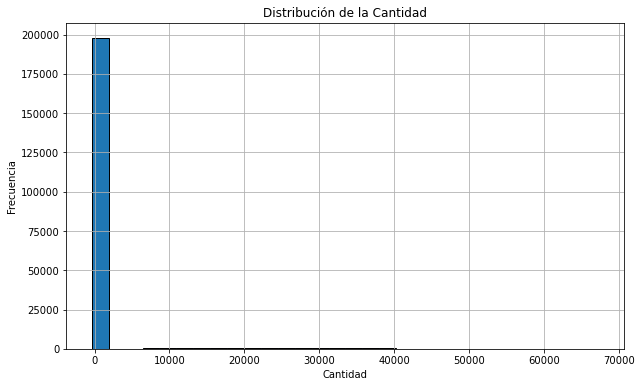

In [63]:
movimientos_pandas = movimientos.select('Cantidad').toPandas()
plt.figure(figsize=(10, 6))
plt.hist(movimientos_pandas['Cantidad'], bins=30, edgecolor='black')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad')
plt.grid(True)
plt.show()

In [65]:
valores_positivos = movimientos_pandas[movimientos_pandas['Cantidad'] > 0]['Cantidad'].count()
valores_negativos = movimientos_pandas[movimientos_pandas['Cantidad'] < 0]['Cantidad'].count()
print(f"Valores por encima de 0: {valores_positivos}")
print(f"Valores por debajo de 0: {valores_negativos}")

Valores por encima de 0: 7129
Valores por debajo de 0: 197158


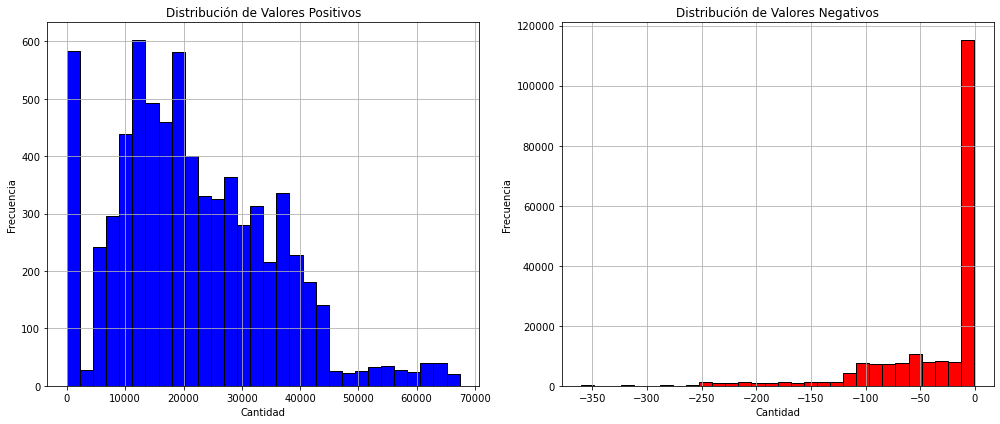

In [68]:
valores_positivos = movimientos_pandas[movimientos_pandas['Cantidad'] > 0]['Cantidad']
valores_negativos = movimientos_pandas[movimientos_pandas['Cantidad'] < 0]['Cantidad']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histograma para valores positivos
ax1.hist(valores_positivos, bins=30, color='blue', edgecolor='black')
ax1.set_xlabel('Cantidad')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Valores Positivos')
ax1.grid(True)

# Histograma para valores negativos
ax2.hist(valores_negativos, bins=30, color='red', edgecolor='black')
ax2.set_xlabel('Cantidad')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Valores Negativos')
ax2.grid(True)

plt.tight_layout()
plt.show()

Lo anterior nos muestra que los datos registran una mayor cantidad de veces los retiros y con una menor freciencia los ingresos, especificamente hay 197.158 registros que reportan retiros (cantidades negativas) frente a tan solo 7.129 registros que reportan valores ingresos (cantidades positivas). Sin embargo, la mayoría de retiros de productos tienen valores bajos (menores a 50) mientras que muchos ingresos tienen valores altos, en la gráfica de distribución de valores positivos se evidencia que gran cantidad de valores se concentran en valores altos (entre 20.000 y 30.000). Lo anterior es lo que provoca que el promedio de la columna cantidad sea un valor positivo.

Además de lo anterior, puede ser útil verificar cuales son las fechas en las que se realiza una mayor cantidad de transacciones (independientemente de la cantidad) o tambien puede interesarnos cuales son los clientes y proveedores que realizan más transacciones. A continuación, se muestra con detalle lo descrito anteriormente (para este análisis asumimos que cada registro representa una transacción).

In [69]:
movimientos.groupby("ClienteID").count().orderBy("count", ascending=False).show(5)

+---------+-----+
|ClienteID|count|
+---------+-----+
|      0.0| 7156|
|    980.0|  409|
|    810.0|  401|
|    804.0|  395|
|    149.0|  395|
+---------+-----+
only showing top 5 rows



La tabla anterior muestra los 5 clientes con mayor cantidad de transacciones, observamos que el cliente con e identificador 0 tiene la mayor cantidad de transacciones, muy superior a los demás. Por lo tanto, considero importante solicitar aclaración al negocio y comprobar si 0 corresponde a un código correcto o es un error en los datos.

In [70]:
movimientos.groupby("ProveedorID").count().orderBy("count", ascending=False).show(5)

+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |197182|
|        4.0|  4832|
|        7.0|  2267|
|        1.0|    11|
+-----------+------+



Como se vio anteriormente, solo existen datos de 3 proveedores, la mayoría de información asociada a este campo se encuentra vacía, pero el proveedor con mayor cantidad de transacciones es el 4.

In [72]:
movimientos.groupby("FechaTransaccion").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|    FechaTransaccion|count|
+--------------------+-----+
|2015-11-03 12:00:...|  331|
|2015-01-21 12:00:...|  326|
|2015-04-14 12:00:...|  323|
|2016-05-04 12:00:...|  323|
|2015-10-06 12:00:...|  317|
|2016-03-23 12:00:...|  314|
|2015-11-24 12:00:...|  309|
|2016-02-24 12:00:...|  307|
|2016-02-26 12:00:...|  304|
|2016-03-22 12:00:...|  304|
+--------------------+-----+
only showing top 10 rows



Lo anterior sugiere que la mayoría de transacciones están registradas en 2015 y 2016 puede de las primeras 10 fechas en las que se reporta mayor cantidad de transacciones 5 son en 2015 y 5 en 2016.

A continuación, revisarmos si existen variables altamente correlacionadas en los datos, encontrando que existe una alta correlación entre el identificador de la factura y de la transacción y entre el tipo de transacción y la cantidad. Se debe consultar al negocio si es necesario mantener todas estas columnas.

In [90]:
corr = movimientos.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,Cantidad
TransaccionProductoID,1.000000,0.017905,-0.001819,0.021868,0.859235,0.060616
ProductoID,0.017905,1.000000,0.028463,-0.009326,0.001007,0.028805
TipoTransaccionID,-0.001819,0.028463,1.000000,-0.277915,-0.484808,0.833650
ClienteID,0.021868,-0.009326,-0.277915,1.000000,0.154670,-0.234709
InvoiceID,0.859235,0.001007,-0.484808,0.154670,1.000000,-0.409633
Cantidad,0.060616,0.028805,0.833650,-0.234709,-0.409633,1.000000


## Análisis de calidad de datos
A continuación validamos la calidad de los datos basados en 4 dimensiones:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

### Unicidad y validez

En este punto debemos veridicar que no existen registros identicos en todas las columnas o que los valores de la llave primaria no se repiten, pues este último atributo no debería repetirse.

In [74]:
# Verificar si existen registros repetidos:
print((movimientos.count()))
print(movimientos.distinct().count())

204292
173659


In [75]:
# Verificar si los valores de la llave primaria se repiten
movimientos.select(countDistinct("TransaccionProductoID")).collect()[0][0]

173659

Lo anterior ya se había evidenciado anteriormente, en conclusión solo hay 173.659 registros únicos. El resto de registros se deberían eliminar.

### Completitud y validez

A continuación, se verifica la cantidad de registros vacíos y las columnas con una cardinalidad superior al 50%.

In [84]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

def contar_blancos(df):
    resultados = []
    for c in df.columns:
        blancos = df.filter(df[c] == '').count()
        if blancos != 0:
            print('Número de blancos para columna ' + c + ': ' + str(blancos))
            resultados.append((c, blancos))
    return resultados

In [81]:
columnas_vacias_movimientos = contar_vacios(movimientos)
columnas_vacias_movimientos

[]

In [86]:
contar_blancos_movimientos = contar_blancos(movimientos)
contar_blancos_movimientos

Número de blancos para columna ProveedorID: 197182
Número de blancos para columna OrdenDeCompraID: 197182


[('ProveedorID', 197182), ('OrdenDeCompraID', 197182)]

In [82]:
columnas_alta_cardinalidad_movimientos = cardinalidad(movimientos)
columnas_alta_cardinalidad_movimientos

{'TransaccionProductoID': 173659}

Lo anterior muestra que existen 2 columnas con 197.182 valores vacíos. Se debe preguntar al negocio porque existe esta gran cantidad de valores vacíos en dos columnas. De lo anterior podemos notar que al hacer el conteo de los valores faltantes revisando los nulos no se retorna ningún valor, por lo que fue necesario crear otra función que revisara los valores en blanco, esto se debe a que ProveedorID y OrdenDeCompraID son datos de tipo string, por lo que las columnas tengan cadenas vacías en lugar de valores nulos.
Por otra parte, la columna TransaccionProductoID es la única que tiene una cardinalidad superior al 50%, es decir, que tiene una alta cantidad de registros distintos, esto tiene sentido pued esta columna representa la llave primaria.

### Consistencia
Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. 
En este caso podríamos verificar que las llaves foraneas existen en las tablas correspondientes, verificar que los datos obligatorios no pueden ser nulos, entre otros. En este caso, ya verificamos los valores nulos, pero ahora verificaremos que las cantidades no sean igual a 0, ya que no tiene sentido reportar un movimiento de 0.

In [89]:
movimientos.filter(col("Cantidad") == 0)

DataFrame[TransaccionProductoID: int, ProductoID: int, TipoTransaccionID: int, ClienteID: double, InvoiceID: double, ProveedorID: string, OrdenDeCompraID: string, FechaTransaccion: string, Cantidad: double]

Como se puede observar no hay registros de cantidad igual a 0, por lo que en ese sentido hay consistencia en los datos.

## Conclusiones/resultados


**Conclusiones generales:**

1. En la tabla de movimientos tenemos información **relacionada con el movimiento, la transacción, el producto, el cliente, el proveedor y con la órden**. 
2. Cada fila representa un movimiento en el inventario, ya sea de ingreso o retiro. En promedio, se registra mayor cantidad de ingresos que de retiros.
3. En total tenemos 204.292 movimientos y 9 variables, de estas hay 3 variables de tipo Integer, 3 variables de tipo Double, y 3 variables de tipo String.
3. Al revisar el tipo de datos se encuentra que todos los identificadores no tienen el mismo tipo de datos aun cuando su estructura es similar ¿por qué?
4. Hay 2 columnas con el 97% de datos vacíos (detalle en conclusiones de calidad).
5. Hay 30.633 registros duplicados.
6. Hay 664 clientes.
7. Hay 3 proveedores.
8. Existe una alta correlación entre el identificador de la factura y de la transacción y entre el tipo de transacción y la cantidad. ¿Debemos mantener las cuatro columnas o es posible eliminar alguna?


**Conclusiones de reglas de negocio:**

1. La llave primaria no tiene valores únicos, se deben eliminar los valores repetidos ya que contiene la misma información en todos los registros.

2. La segunda regla no se cumple por completo, en primer lugar, la cantidad de movimientos reportados no coincide con los datos, ya que en la tabla de movimientos hay una menor cantidad de registros, además existen registros completamente duplicados que deben ser eliminados.  Por otra parte, aunque la primera fecha si corresponde a 2013, solo hay registros del 31 de diciembre en ese año ¿hacen falta datos o se reporto erradamente la cantidad de información disponible). 

2. La tercera regla tampoco se cumple pues la cantidad de clientes asociados no puede superar la cantidad de movimientos. Además, se encontro muchos clientes cuyo identificador es 0 ¿hay un error o es un identificador valido?

3. La única columna asociada a la fecha no cumple con el formato indicado para todos sus registros, sin embargo, solo es necesario ajustar el formato para que coincida con el deseado ¿es posible que realicemos este ajuste? 

4. La información de la cantidad de proveedores no es cierta, en la tabla solo se encontraron 3 y muchos registros de esta columna estaban vacíos ¿se puede completar esta información o se puede eliminar esta variable?

**Conclusiones de calidad:**

1.  Las columnas ProveedorID y OrdenDeCompraID tienen 197.182 valores vacíos ¿por qué a ambas columnas les hace falta la misma cantidad de información?, ¿se pueden eliminar?. El resto de variables no tienen valores vacíos.

2. Se identificaron valores extremos en la variable Cantidad, esto se evidencia al revisar los percentiles, ya que para el 75% de los datos, el valor de Cantidad no superaba -5, pero el valor máximo es 67.368. Esto tambien se observa en los gráficos de valores positivos y negativos, mientras que para los valores negativos la frencuencia más alta es superior a 100.000, para los valores positivos la frecuencia más alta apenas supera levemente los 600.

3. Únicamente la columna TransaccionProductoID tiene una alta cardinalidad.

**Conclusiones de consultoria**

En atención a la solicitud de revisar los datos, concluimos que es posible trabajar con los datos de movimientosCopia, pero es necesario que el negocio revise las observaciones y consultas realizadas anteriormente para proceder a realizar los ajustes necesarios para organizar los datos adecuadamente. 